In [214]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ta

# to run async code in jupyter notebook
import nest_asyncio
nest_asyncio.apply()

API_KEY = None
SECRET_KEY = None

import os
from dotenv import load_dotenv

load_dotenv(override=True)

if API_KEY is None:
    API_KEY = os.environ.get('ALP_API_KEY')

if SECRET_KEY is None:
    SECRET_KEY = os.environ.get('ALP_SEC_KEY')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [215]:
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo

from alpaca.trading.client import TradingClient
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
from alpaca.data.historical.corporate_actions import CorporateActionsClient
from alpaca.data.historical.stock import StockHistoricalDataClient
from alpaca.trading.stream import TradingStream
from alpaca.data.live.stock import StockDataStream

from alpaca.data.requests import (
    CorporateActionsRequest,
    StockBarsRequest,
    StockQuotesRequest,
    StockTradesRequest,
)

from alpaca.data.enums import Adjustment

In [216]:
from regime_tickers import custom_volatility_subset

In [217]:
stock_historical_data_client = StockHistoricalDataClient(API_KEY, SECRET_KEY)

# alpaca has no older data than 2016-01-04 for this symbol set
earliest_date = datetime(2016, 1, 4, tzinfo=ZoneInfo('America/New_York'))
# earliest_timestamps_by_symbol = df_adj.reset_index().groupby('symbol')['timestamp'].min()

req = StockBarsRequest(
    symbol_or_symbols = custom_volatility_subset + ['SPY'],  # add SPY for market reference
    timeframe=TimeFrame(amount = 1, unit = TimeFrameUnit.Day), 
    start = earliest_date,                    
    limit = None,    
    adjustment=Adjustment('all') # adjust for splits and dividends                                           
)
df_adj = stock_historical_data_client.get_stock_bars(req).df.reset_index().set_index('timestamp')
df_adj = df_adj.sort_values(by=['symbol', 'timestamp']) # Ensure sorted for correct rolling calcs


In [218]:
pd.set_option('display.max_rows', 300)
print("Total NANs:", df_adj.pivot(columns="symbol").isna().sum().sum())
print(df_adj.pivot(columns="symbol").isna().sum())

pd.reset_option('display.max_rows')

Total NANs: 0
             symbol
open         GLD       0
             HYG       0
             IWM       0
             QQQ       0
             SPY       0
             VIXY      0
high         GLD       0
             HYG       0
             IWM       0
             QQQ       0
             SPY       0
             VIXY      0
low          GLD       0
             HYG       0
             IWM       0
             QQQ       0
             SPY       0
             VIXY      0
close        GLD       0
             HYG       0
             IWM       0
             QQQ       0
             SPY       0
             VIXY      0
volume       GLD       0
             HYG       0
             IWM       0
             QQQ       0
             SPY       0
             VIXY      0
trade_count  GLD       0
             HYG       0
             IWM       0
             QQQ       0
             SPY       0
             VIXY      0
vwap         GLD       0
             HYG       0
             IWM

In [219]:
############## windows = [5, 20, 60]
windows = [20]

In [220]:
# Calculate Average True Range (ATR) normalized by close price
def compute_atr_per_symbol(group, windows=windows):
    for w in windows:
        atr = ta.volatility.AverageTrueRange(
            high=group['high'], 
            low=group['low'], 
            close=group['close'], 
            window=w
        )
        group[f'atr_norm_{w}'] = atr.average_true_range()
        
        # Normalize ATR using 'adj_close' if available, otherwise use 'close'
        group[f'atr_norm_{w}'] = group[f'atr_norm_{w}'] / group['close']

    return group

# Reapply to your DataFrame
df_adj = df_adj.groupby('symbol', group_keys=False).apply(compute_atr_per_symbol)

C:\Users\sergi\AppData\Local\Temp\ipykernel_12544\3889345209.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_adj = df_adj.groupby('symbol', group_keys=False).apply(compute_atr_per_symbol)


In [221]:
# Calculate Daily Log Returns
df_adj['log_returns'] = df_adj.groupby('symbol')['close'].transform(lambda x: np.log(x / x.shift(1)))

In [222]:
z_window = 60

In [223]:
# Rolling Standard Deviation (Volatility). For further computations, later we will use z-scores of these values only
for w in windows:
    df_adj[f'rolling_std_20'] = df_adj.groupby('symbol')['log_returns'].transform(
        lambda x: x.rolling(window=w, min_periods=w).std()
    )

    df_adj[f'z_rolling_std_20'] = df_adj.groupby('symbol')[f'rolling_std_20'].transform(
        lambda x: (x - x.rolling(z_window).mean()) / x.rolling(z_window).std()
    )

In [224]:
# Range Ratio (High - Low) / Close, per asset
df_adj['range_ratio'] = (df_adj['high'] - df_adj['low']) / df_adj['close']
# Adding smoothing (e.g., rolling average of 5 days)
df_adj['range_ratio_smooth'] = df_adj.groupby('symbol')['range_ratio'].transform(lambda x: x.rolling(5).mean())
# Standardizing with Z-scores for regime shift detection
df_adj['z_range_ratio_smooth'] = df_adj.groupby('symbol')['range_ratio_smooth'].transform(lambda x: (x - x.rolling(z_window).mean()) / x.rolling(z_window).std())

df_adj.drop(columns=['range_ratio', 'range_ratio_smooth'], inplace=True)

In [225]:
# Volatility Shock Count
# The number of days in a recent lookback window where daily returns exceeded 2 standard deviations, either up or down.
# It captures the frequency of abnormal moves — a key indicator for risk, panic clusters, or momentum bursts.

# 1. Calculate return z-scores per symbol
df_adj['z_log_returns'] = df_adj.groupby('symbol')['log_returns'].transform(
    lambda x: (x - x.rolling(60).mean()) / x.rolling(60).std()
)

# 2. Count shocks in rolling window (e.g., abs(z) > 2 over last 20 days)
df_adj['vol_shock_count_20'] = df_adj.groupby('symbol')['z_log_returns'].transform(
    lambda x: x.rolling(20).apply(lambda r: (abs(r) > 2).sum(), raw=True)
)

df_adj.drop(columns=['log_returns'], inplace=True)

In [226]:
df_adj = df_adj.sort_values(by=['symbol', 'timestamp'])

In [227]:
df_pivot = df_adj.pivot(columns="symbol")
# Flatten columns ('close', 'QQQ') -> 'close_QQQ'
df_pivot.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_pivot.columns]

In [228]:
# Volatility Cross-Asset Dispersion lets you measure how much the volatility levels themselves are diverging across assets. It's like saying: are
#  all sectors jittery together or are some calm while others are chaotic? Great for reading the market’s internal stress or divergence.

# Step 1: Filter only the 'rolling_std_20' columns
rolling_std_cols = [col for col in df_pivot.columns if col.startswith('rolling_std_20_')]

# Step 2: Compute cross-sectional std (dispersion) across symbols for each timestamp
vol_dispersion = df_pivot[rolling_std_cols].std(axis=1)

# Step 3: Add back into df_pivot as a new column
df_pivot['volatility_dispersion'] = vol_dispersion

In [229]:
# Realized Vol / Implied Vol compares actual historical price movement (realized vol) with what the market expects (implied vol). 
# A ratio >1 means realized volatility has exceeded market expectations — a sign of surprise, dislocation, or a catch-up in pricing. 
# A ratio <1 suggests implied vol is elevated — often in times of uncertainty or hedging demand.

# Z-realized vs Implied Volatility Ratios

# Reference realized vol
realized = df_pivot['rolling_std_20_IWM']

# Loop over each implied asset and compute z-scored realized/implied ratios
implied = df_pivot['rolling_std_20_VIXY']
ratio = realized / implied
z_col = f'z_realized_implied_vixy'

df_pivot[z_col] = (ratio - ratio.rolling(z_window).mean()) / ratio.rolling(z_window).std()


In [230]:
# Volatility Spread = VIXY implied vol proxy – realized vol of SPY/IWM
# Z-score Level	What It Means
# > +2	Implied vol (VIXY) is much higher than realized vol → Fear spike
# < -2	Realized vol is unusually high vs what’s priced in → Complacency mispricing?
# Around 0	Implied and realized vol are in sync → Stable regime

# Step 1: Compute average realized vol of SPY and IWM
realized_avg = df_pivot[['rolling_std_20_SPY', 'rolling_std_20_IWM']].mean(axis=1)

# Step 2–4: Loop over implied assets to compute z-scored spread and clean up
spread = df_pivot['rolling_std_20_VIXY'] - realized_avg
z_col = f'z_vol_spread_vixy'

df_pivot[z_col] = (spread - spread.rolling(z_window).mean()) / spread.rolling(z_window).std()

In [231]:
# Volatility Skew = Difference in realized vol between two symbols
# QQQ vs SPY — Big Tech vs Broad Market - IWM vs SPY — Small Caps vs Broad Market - GLD vs SPY — Gold vs Broad Market
# Define the assets to compare against SPY
skew_assets = ['QQQ', 'IWM', 'GLD']

# Loop to compute z-scored volatility skew vs SPY
for ticker in skew_assets:
    spread = df_pivot[f'rolling_std_20_{ticker}'] - df_pivot['rolling_std_20_SPY']
    z_col = f'z_vol_skew_{ticker.lower()}'
    
    df_pivot[z_col] = (spread - spread.rolling(z_window).mean()) / spread.rolling(z_window).std()

In [232]:
# Drop 'SPY' columns to avoid redundancy, they where just used for comparison
df_pivot.drop(columns=[col for col in df_pivot.columns if 'SPY' in col], inplace=True)

# Drop 'rolling_std_20' columns to avoid redundancy, they where just used for comparison, we keep z-scores only
# Drop columns that start with 'rolling_std_20'
df_pivot.drop(columns=[col for col in df_pivot.columns if col.startswith("rolling_std_20")], inplace=True)

In [233]:
# after 2*max(windows) +z_window -1 days, not nans
print(df_pivot[max(windows)+z_window-1:].isna().sum().sum()) 

df_pivot_clean = df_pivot[max(windows)+z_window-1:]

0


In [234]:
# # Check feature stationarity using Augmented Dickey-Fuller test
# # p-value > 0.1 = likely non-stationary (bad for PCA)
# from statsmodels.tsa.stattools import adfuller

# stationary_features = []
# for col in df_pivot_clean.columns:
#     result = adfuller(df_pivot_clean[col])
#     if result[1] < 0.1:
#         stationary_features.append(col)

# # print which features are stationary, to keep for PCA
# from collections import Counter
# prefixes = [ "_".join(v.split("_")[:-1]) for v in stationary_features ]
# print(Counter(prefixes))

# #df_stationary = df_pivot_clean[stationary_features]

In [235]:
df_stationary = df_pivot_clean.drop(
    columns=[col for col in df_pivot_clean.columns if any(x in col for x in ["vwap", "low", "high", "close", "open", "volume", "trade_count", "atr", "z_log_returns"])],
)

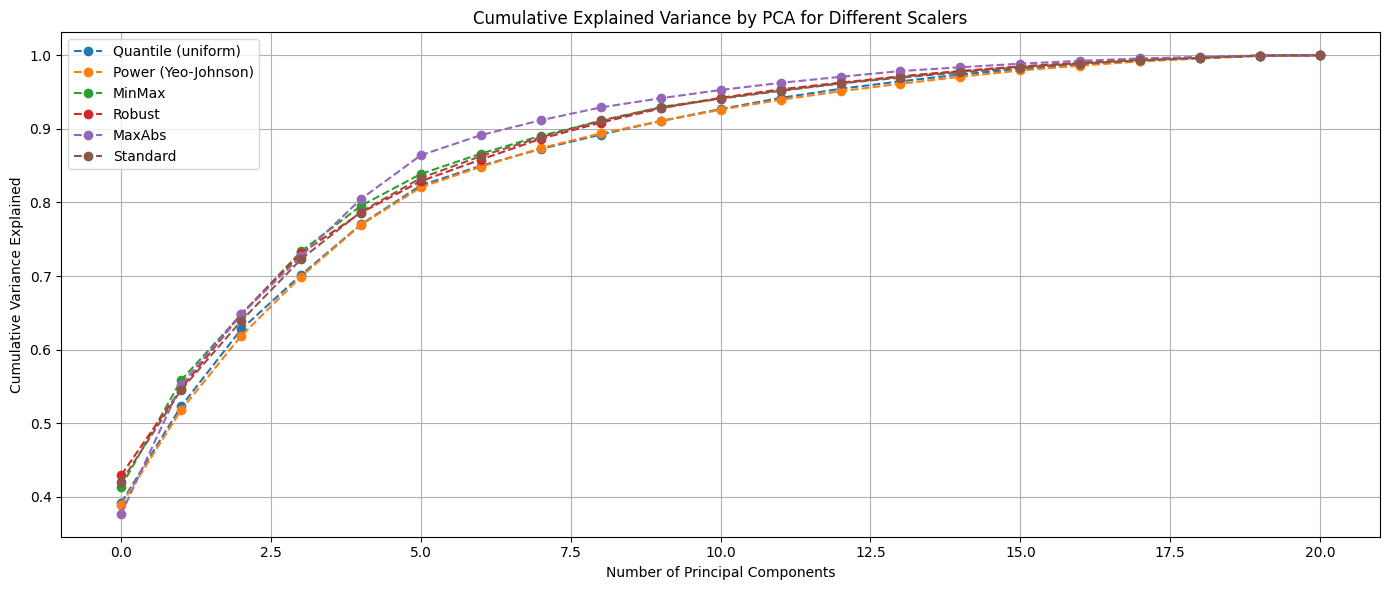

In [236]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Prepare scalers in a dict for easy iteration
scalers = {
    "Quantile (uniform)": QuantileTransformer(output_distribution='uniform', random_state=0),
    "Power (Yeo-Johnson)": PowerTransformer(method='yeo-johnson'),
    "MinMax": MinMaxScaler(),
    "Robust": RobustScaler(),
    "MaxAbs": MaxAbsScaler(),
    "Standard": StandardScaler(),
}

# Store cumulative variance per scaler
cum_variances = {}

for name, scaler in scalers.items():
    try:
        scaled = scaler.fit_transform(df_stationary)
        pca = PCA()
        X_pca = pca.fit_transform(scaled)
        cum_var = np.cumsum(pca.explained_variance_ratio_)
        cum_variances[name] = cum_var
    except Exception as e:
        print(f"Skipping {name} due to error: {e}")

# Plot all in one figure
plt.figure(figsize=(14, 6))

for name, cum_var in cum_variances.items():
    plt.plot(cum_var, marker='o', linestyle='--', label=name)

plt.title("Cumulative Explained Variance by PCA for Different Scalers")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Variance Explained")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


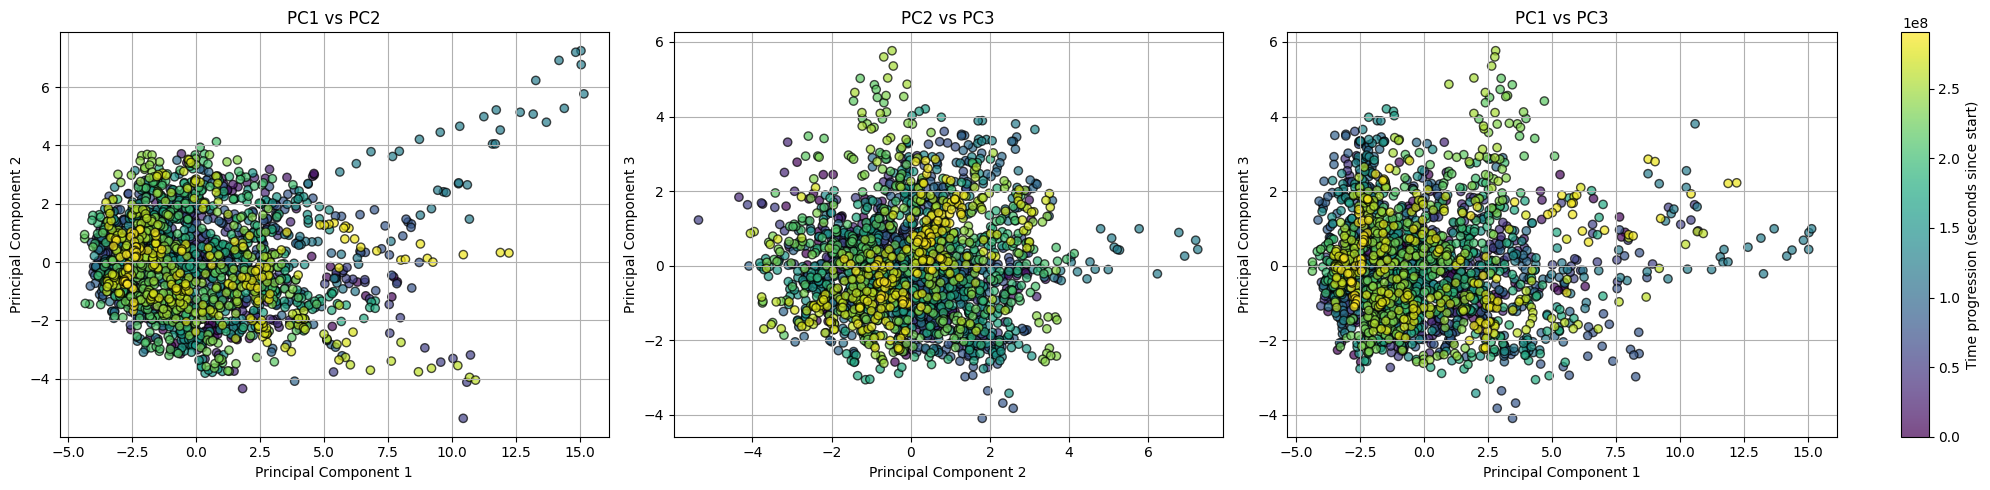

In [237]:
import matplotlib.gridspec as gridspec

import numpy as np

# Convert timestamps to numeric
timestamps = pd.to_datetime(df_pivot_clean.index)
time_numeric = (timestamps - timestamps.min()).total_seconds()

# Set up figure with gridspec
fig = plt.figure(figsize=(20, 5))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05])  # Last column for colorbar

# Common colormap
cmap = plt.cm.viridis

# Plot 1: PC1 vs PC2
ax0 = plt.subplot(gs[0])
sc0 = ax0.scatter(X_pca[:, 0], X_pca[:, 1], c=time_numeric, cmap=cmap, alpha=0.7, edgecolors='k')
ax0.set_title("PC1 vs PC2")
ax0.set_xlabel("Principal Component 1")
ax0.set_ylabel("Principal Component 2")
ax0.grid(True)

# Plot 2: PC2 vs PC3
ax1 = plt.subplot(gs[1])
sc1 = ax1.scatter(X_pca[:, 1], X_pca[:, 2], c=time_numeric, cmap=cmap, alpha=0.7, edgecolors='k')
ax1.set_title("PC2 vs PC3")
ax1.set_xlabel("Principal Component 2")
ax1.set_ylabel("Principal Component 3")
ax1.grid(True)

# Plot 3: PC1 vs PC3
ax2 = plt.subplot(gs[2])
sc2 = ax2.scatter(X_pca[:, 0], X_pca[:, 2], c=time_numeric, cmap=cmap, alpha=0.7, edgecolors='k')
ax2.set_title("PC1 vs PC3")
ax2.set_xlabel("Principal Component 1")
ax2.set_ylabel("Principal Component 3")
ax2.grid(True)

# Add a colorbar in the dedicated subplot
cax = plt.subplot(gs[3])
cb = plt.colorbar(sc2, cax=cax)
cb.set_label("Time progression (seconds since start)")

plt.tight_layout()
plt.show()


In [238]:
# Define scalers
scalers = {
    "Quantile (uniform)": QuantileTransformer(output_distribution='uniform', random_state=0),
    "Power (Yeo-Johnson)": PowerTransformer(method='yeo-johnson'),
    "MinMax": MinMaxScaler(),
    "Robust": RobustScaler(),
    "MaxAbs": MaxAbsScaler(),
    "Standard": StandardScaler(),
}

# Loop through each scaler
for name, scaler in scalers.items():
    print(f"\n🔍 Scaler: {name}\n")

    # Scale the data
    scaled = scaler.fit_transform(df_stationary)

    # Apply PCA to retain 80% of variance
    pca = PCA(n_components=0.8)
    X_pca = pca.fit_transform(scaled)

    # Create PCA DataFrame
    pca_df = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

    # Display PCA loadings
    print("📊 PCA Component Loadings (Original Feature Contributions)\n")
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=[f"PC{i+1}" for i in range(pca.n_components_)],
        index=df_stationary.columns
    )

    # Stylish display
    loadings_styled = (
        loadings.style
        .format(precision=2)
        .background_gradient(cmap='coolwarm', axis=0)
        .set_caption(f"📊 PCA Loadings — {name}")
    )

    display(loadings_styled)


🔍 Scaler: Quantile (uniform)

📊 PCA Component Loadings (Original Feature Contributions)



,PC1,PC2,PC3,PC4,PC5,PC6
z_rolling_std_20_GLD,0.10,0.23,0.46,-0.03,-0.11,-0.06
z_rolling_std_20_HYG,0.24,0.19,-0.09,-0.11,-0.06,0.33
z_rolling_std_20_IWM,0.26,0.16,-0.04,-0.20,0.13,-0.17
z_rolling_std_20_QQQ,0.27,0.08,-0.11,0.13,-0.24,-0.14
z_rolling_std_20_VIXY,0.26,-0.26,0.09,-0.13,0.01,-0.04
z_range_ratio_smooth_GLD,0.09,0.09,0.33,0.25,0.12,0.08
z_range_ratio_smooth_HYG,0.22,0.06,0.00,0.20,0.23,0.26
z_range_ratio_smooth_IWM,0.20,0.01,0.04,0.26,0.41,-0.08
z_range_ratio_smooth_QQQ,0.21,-0.03,-0.01,0.42,0.22,-0.01
z_range_ratio_smooth_VIXY,0.18,-0.18,0.07,0.30,0.32,0.03



🔍 Scaler: Power (Yeo-Johnson)

📊 PCA Component Loadings (Original Feature Contributions)



,PC1,PC2,PC3,PC4,PC5,PC6
z_rolling_std_20_GLD,0.11,0.24,0.48,-0.21,-0.15,0.03
z_rolling_std_20_HYG,0.25,0.20,-0.13,-0.14,-0.01,-0.38
z_rolling_std_20_IWM,0.28,0.21,-0.07,-0.16,0.22,0.11
z_rolling_std_20_QQQ,0.29,0.09,-0.16,-0.02,-0.30,0.14
z_rolling_std_20_VIXY,0.29,-0.26,0.06,-0.16,0.09,0.07
z_range_ratio_smooth_GLD,0.11,0.11,0.43,0.20,-0.08,-0.05
z_range_ratio_smooth_HYG,0.24,0.09,0.06,0.28,0.11,-0.29
z_range_ratio_smooth_IWM,0.23,0.06,0.11,0.39,0.25,0.09
z_range_ratio_smooth_QQQ,0.24,0.00,0.06,0.46,-0.02,0.05
z_range_ratio_smooth_VIXY,0.21,-0.17,0.15,0.38,0.14,0.03



🔍 Scaler: MinMax

📊 PCA Component Loadings (Original Feature Contributions)



,PC1,PC2,PC3,PC4,PC5,PC6
z_rolling_std_20_GLD,0.12,0.18,-0.23,0.49,-0.20,0.01
z_rolling_std_20_HYG,0.26,0.20,-0.08,-0.15,-0.04,-0.40
z_rolling_std_20_IWM,0.28,0.19,-0.09,-0.09,0.23,0.08
z_rolling_std_20_QQQ,0.29,0.08,0.01,-0.22,-0.34,0.14
z_rolling_std_20_VIXY,0.26,-0.22,-0.11,0.01,0.10,0.07
z_range_ratio_smooth_GLD,0.11,0.06,0.09,0.38,-0.12,-0.05
z_range_ratio_smooth_HYG,0.23,0.08,0.25,0.09,0.04,-0.27
z_range_ratio_smooth_IWM,0.26,0.08,0.41,0.17,0.21,0.04
z_range_ratio_smooth_QQQ,0.26,0.00,0.46,0.11,-0.10,0.06
z_range_ratio_smooth_VIXY,0.23,-0.15,0.35,0.19,0.13,0.02



🔍 Scaler: Robust

📊 PCA Component Loadings (Original Feature Contributions)



,PC1,PC2,PC3,PC4,PC5,PC6
z_rolling_std_20_GLD,0.12,0.22,0.19,0.45,-0.07,0.05
z_rolling_std_20_HYG,0.22,0.18,-0.08,-0.10,-0.01,-0.34
z_rolling_std_20_IWM,0.24,0.14,-0.07,-0.06,0.23,0.13
z_rolling_std_20_QQQ,0.22,0.04,-0.10,-0.12,-0.30,0.14
z_rolling_std_20_VIXY,0.26,-0.26,-0.15,0.15,0.10,0.05
z_range_ratio_smooth_GLD,0.15,0.06,0.48,0.36,-0.16,-0.03
z_range_ratio_smooth_HYG,0.30,-0.00,0.29,-0.20,0.06,-0.36
z_range_ratio_smooth_IWM,0.26,-0.06,0.35,-0.20,0.21,0.10
z_range_ratio_smooth_QQQ,0.25,-0.14,0.32,-0.23,-0.14,0.12
z_range_ratio_smooth_VIXY,0.25,-0.32,0.29,-0.09,0.12,0.06



🔍 Scaler: MaxAbs

📊 PCA Component Loadings (Original Feature Contributions)



,PC1,PC2,PC3,PC4,PC5
z_rolling_std_20_GLD,0.14,0.15,-0.44,-0.34,-0.49
z_rolling_std_20_HYG,0.29,0.18,0.08,-0.22,0.05
z_rolling_std_20_IWM,0.31,0.22,-0.07,-0.18,0.23
z_rolling_std_20_QQQ,0.35,0.07,0.31,-0.16,-0.12
z_rolling_std_20_VIXY,0.26,-0.18,-0.10,-0.15,0.15
z_range_ratio_smooth_GLD,0.10,0.03,-0.23,0.07,-0.28
z_range_ratio_smooth_HYG,0.26,0.07,-0.08,0.22,-0.05
z_range_ratio_smooth_IWM,0.29,0.09,-0.19,0.43,0.01
z_range_ratio_smooth_QQQ,0.31,-0.00,-0.01,0.46,-0.17
z_range_ratio_smooth_VIXY,0.24,-0.13,-0.18,0.37,0.00



🔍 Scaler: Standard

📊 PCA Component Loadings (Original Feature Contributions)



,PC1,PC2,PC3,PC4,PC5,PC6
z_rolling_std_20_GLD,0.13,0.27,0.47,-0.16,-0.15,0.01
z_rolling_std_20_HYG,0.24,0.17,-0.15,-0.03,-0.01,-0.36
z_rolling_std_20_IWM,0.27,0.16,-0.10,-0.05,0.23,0.06
z_rolling_std_20_QQQ,0.27,0.03,-0.19,0.03,-0.30,0.11
z_rolling_std_20_VIXY,0.27,-0.27,0.07,-0.16,0.10,0.08
z_range_ratio_smooth_GLD,0.13,0.11,0.44,0.18,-0.11,-0.04
z_range_ratio_smooth_HYG,0.24,0.04,0.06,0.32,0.07,-0.26
z_range_ratio_smooth_IWM,0.23,0.02,0.11,0.41,0.21,0.04
z_range_ratio_smooth_QQQ,0.23,-0.06,0.07,0.44,-0.07,0.07
z_range_ratio_smooth_VIXY,0.21,-0.21,0.18,0.33,0.13,0.05



🔍 Scaler: Quantile (uniform)


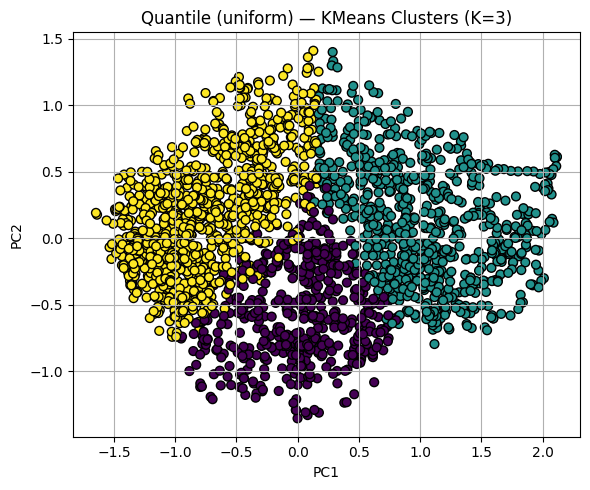

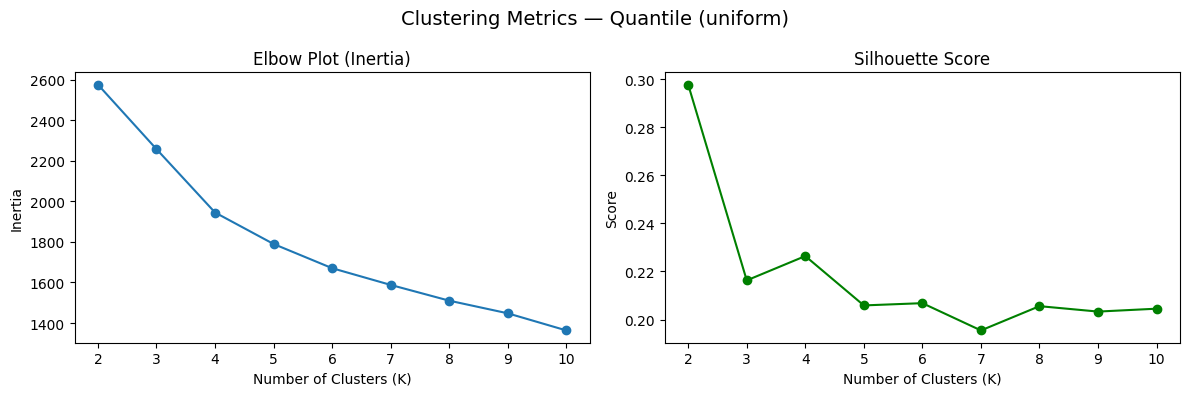


🔍 Scaler: Power (Yeo-Johnson)


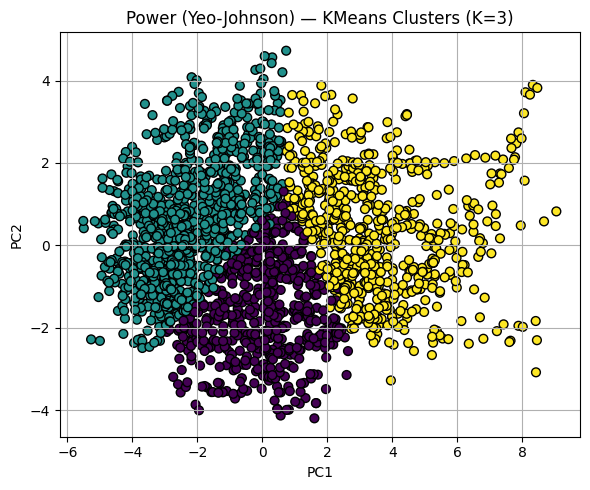

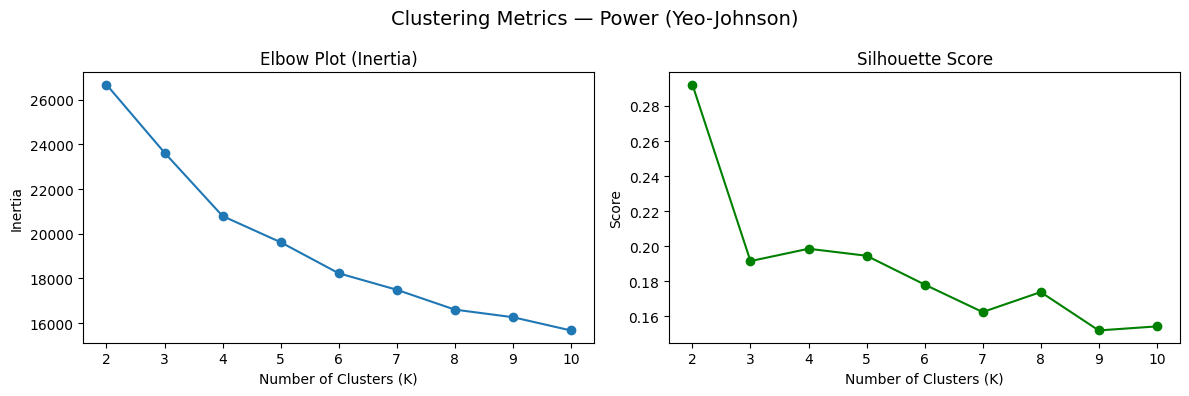


🔍 Scaler: MinMax


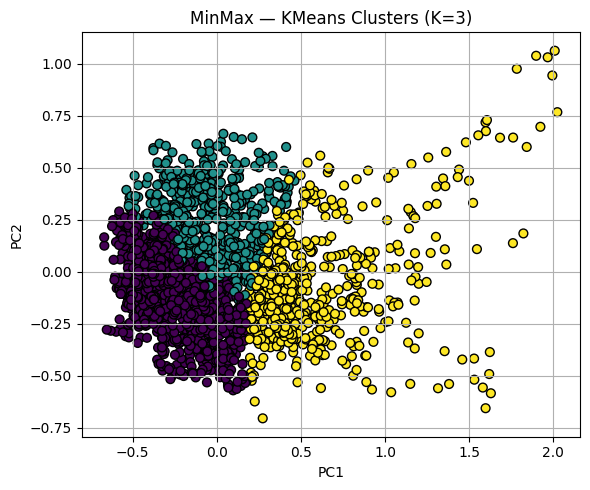

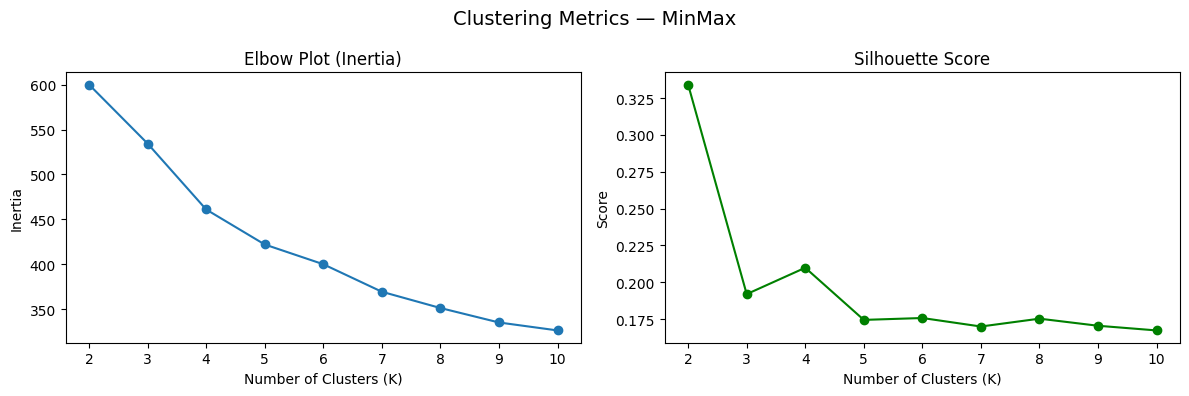


🔍 Scaler: Robust


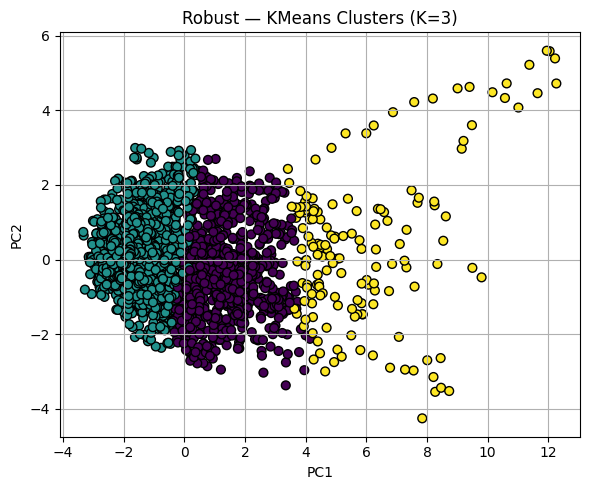

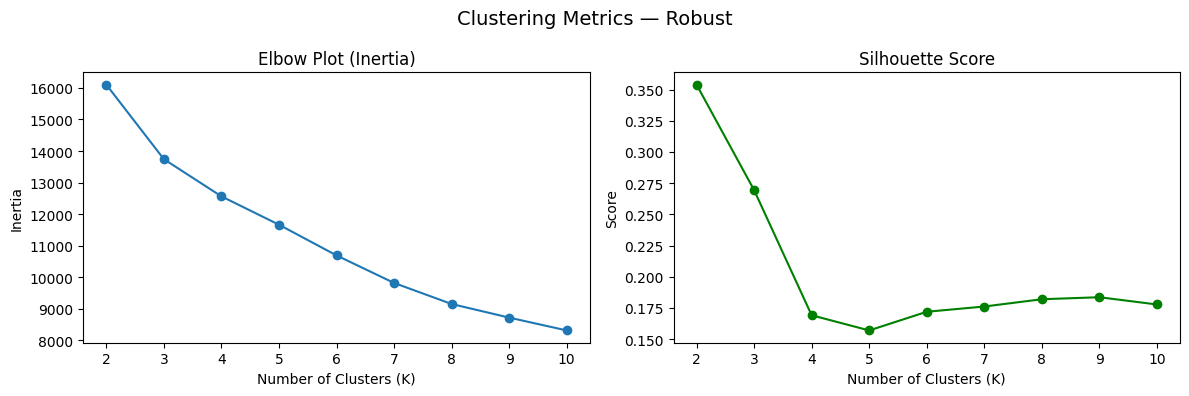


🔍 Scaler: MaxAbs


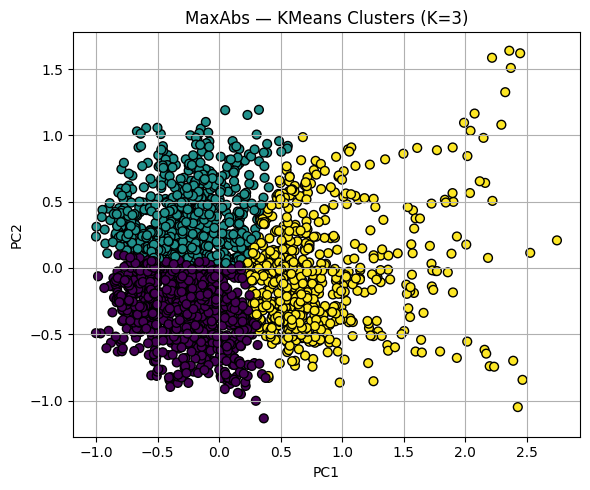

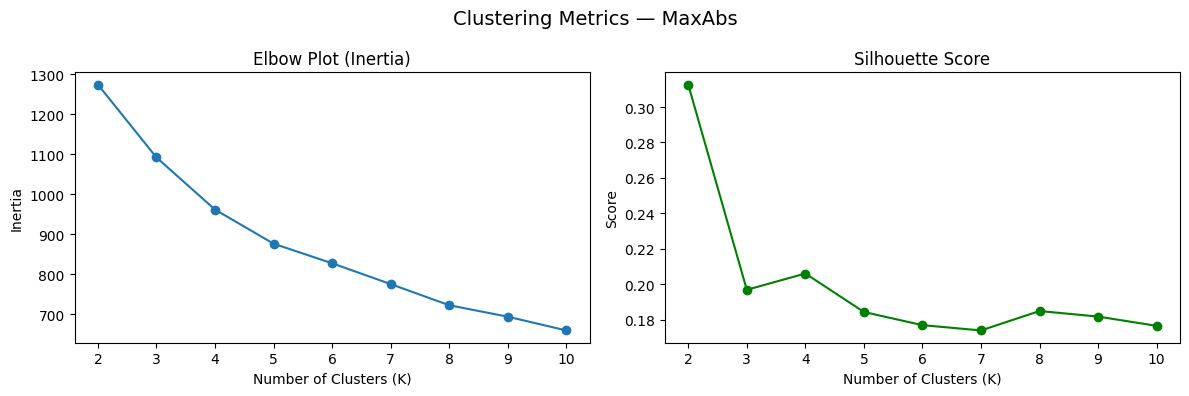


🔍 Scaler: Standard


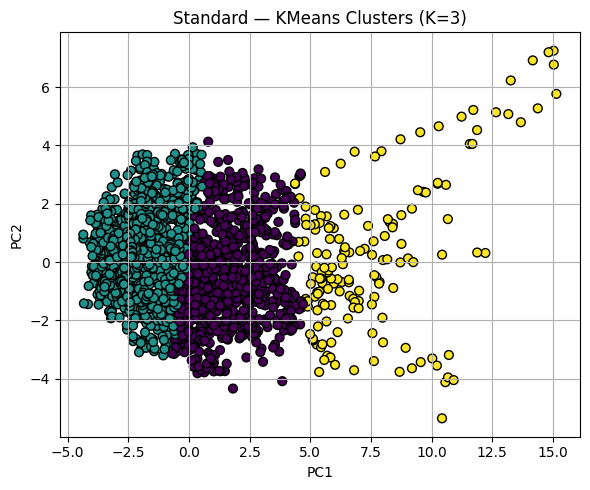

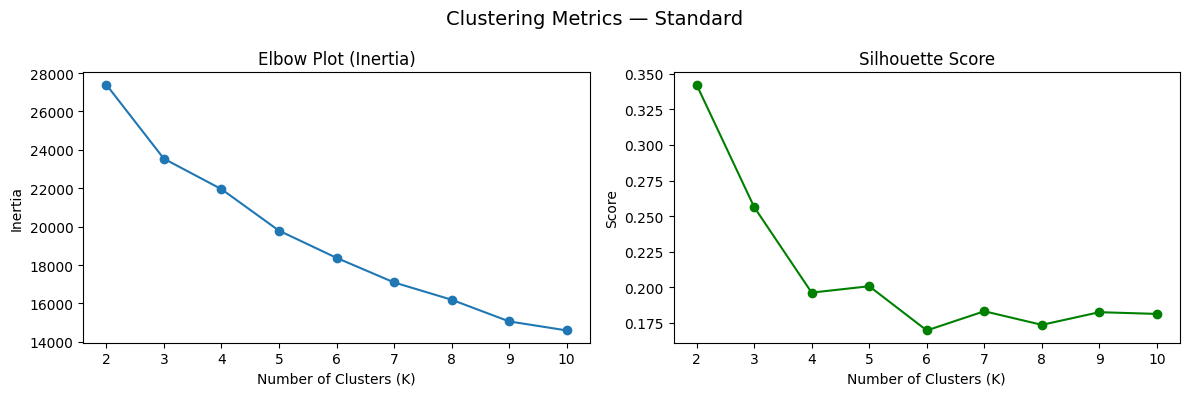

In [244]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import (
    QuantileTransformer, PowerTransformer, MinMaxScaler,
    RobustScaler, MaxAbsScaler, StandardScaler
)
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define scalers
scalers = {
    "Quantile (uniform)": QuantileTransformer(output_distribution='uniform', random_state=0),
    "Power (Yeo-Johnson)": PowerTransformer(method='yeo-johnson'),
    "MinMax": MinMaxScaler(),
    "Robust": RobustScaler(),
    "MaxAbs": MaxAbsScaler(),
    "Standard": StandardScaler(),
}

# Range of K values to test
k_range = range(2, 11)

# Store results
results = {}

for name, scaler in scalers.items():
    print(f"\n🔍 Scaler: {name}")

    # Step 1: Scale the data
    scaled = scaler.fit_transform(df_stationary)


    # Step 3: Apply PCA
    pca = PCA(n_components=0.8)
    X_pca = pca.fit_transform(scaled)

    inertias = []
    silhouettes = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=0)
        labels = kmeans.fit_predict(X_pca)

        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(X_pca, labels))

        # 📊 Plot clusters for K=2 and K=3
        if k in [3]:
            plt.figure(figsize=(6, 5))
            plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=40, edgecolor='k')
            plt.title(f"{name} — KMeans Clusters (K={k})")
            plt.xlabel("PC1")
            plt.ylabel("PC2")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    # Store results
    results[name] = {
        "inertia": inertias,
        "silhouette": silhouettes
    }

    # 📈 Plot Elbow and Silhouette Score
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f"Clustering Metrics — {name}", fontsize=14)

    # Elbow Plot
    ax[0].plot(k_range, inertias, marker='o')
    ax[0].set_title("Elbow Plot (Inertia)")
    ax[0].set_xlabel("Number of Clusters (K)")
    ax[0].set_ylabel("Inertia")

    # Silhouette Score Plot
    ax[1].plot(k_range, silhouettes, marker='o', color='green')
    ax[1].set_title("Silhouette Score")
    ax[1].set_xlabel("Number of Clusters (K)")
    ax[1].set_ylabel("Score")

    plt.tight_layout()
    plt.show()


In [245]:
### creo que es mejor entrenar un modelo para cada combinacion de clusters. kmeans con Wasserstein distance nos da hard labels, mas simple,
# GMM nos da soft labels (probs), mas complejo, pero podria apañar algo como threholds the probs, es decir un modelo para cuando la probabilidad de 
# cluster 1 es mayor que 0.5, otro para cuando es mayor que 0.7, etc.

In [246]:
print("\n--- Explained Variance Ratio ---")
print(pca.explained_variance_ratio_)
print(f"Total variance explained by {X_pca.shape[1]} components: {pca.explained_variance_ratio_.sum():.2f}")


--- Explained Variance Ratio ---
[0.42064437 0.12481511 0.09346726 0.08400493 0.06425495 0.04605628]
Total variance explained by 6 components: 0.83


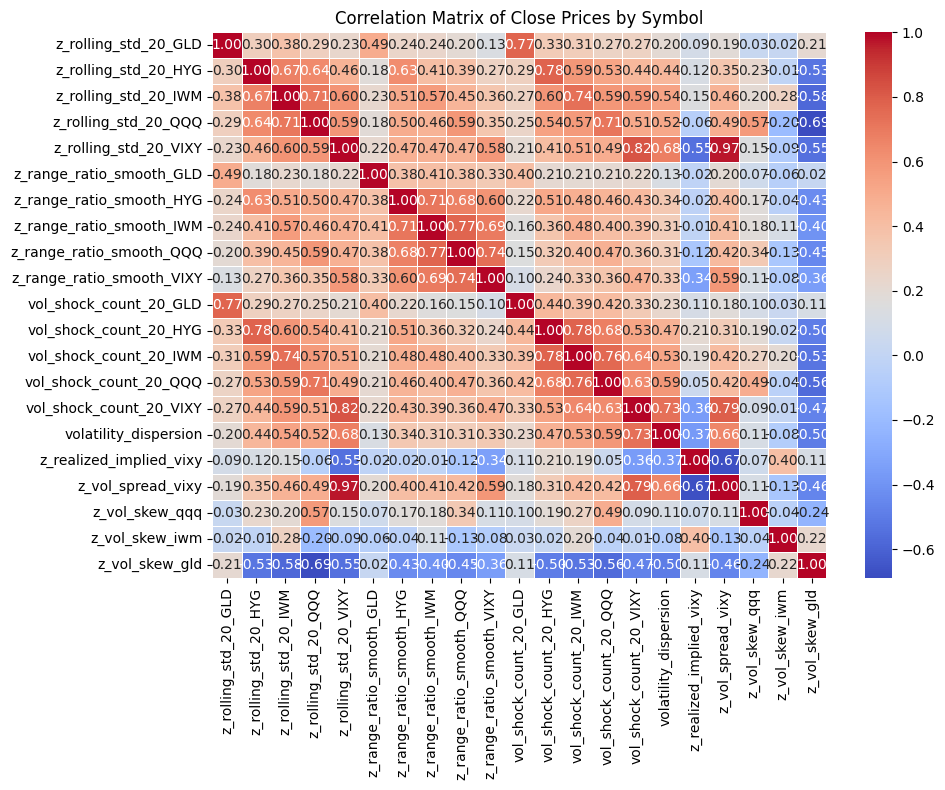

In [247]:
## BUSCAR UN GRUPO QUE NO TENGA UNA CORRELACION ALTA?????

# # # ##### Correlation Heatmap #####
import seaborn as sns
import matplotlib.pyplot as plt


# Optionally drop rows with missing values to ensure clean correlation
corr_df = df_stationary.dropna()

# Compute the correlation matrix
correlation_matrix = corr_df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix of Close Prices by Symbol")
plt.tight_layout()
plt.show()


KeyError: 'log_returns'

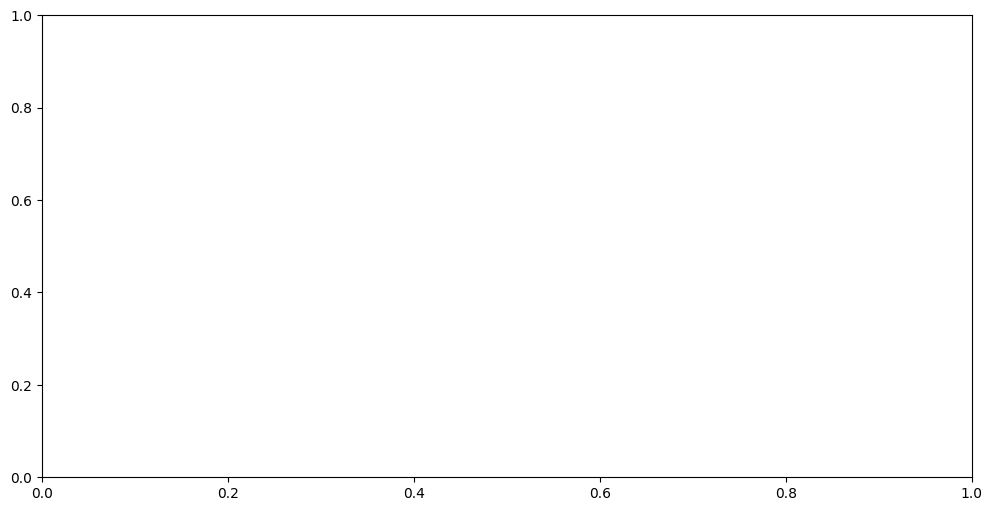

In [248]:
import matplotlib.pyplot as plt

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

for symbol in ['UVXY', 'VIXY']:
    subset = df_adj[df_adj['symbol'] == symbol]
    ax.plot(subset.index, subset['log_returns'], label=symbol)

ax.set_title('Close Prices: PDBC vs DBC')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()
